In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV

from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns

from datetime import datetime

## 0. Load data

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams.update({'font.size': 14})

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [48]:
TRAIN_DATASET_PATH = './data/train.csv'
TEST_DATASET_PATH = './data/test.csv'
SAMPLE_SUBMISSION_PATH = './data/sample_submission.csv'
SEPARATOR = ','

In [5]:
def evaluate_preds(
    train_true_values: np.ndarray,
    train_pred_values: np.ndarray,
    test_true_values: np.ndarray,
    test_pred_values: np.ndarray
) -> None:
    print(f"Train R2:\t{round(r2(train_true_values, train_pred_values),3)}")
    print(f"Test R2:\t{round(r2(test_true_values, test_pred_values), 3)}")
    
    x_label = "Predicted values"
    y_label = "True values"
    title = "Train sample prediction"
    plt.figure(figsize=(18, 10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    
    plt.show()


In [6]:
data = pd.read_csv(TRAIN_DATASET_PATH, sep=SEPARATOR)
data.head()

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0  11809          27    3.0  115.027311         NaN           10.0      4   
1   3013          22    1.0   39.832524   23.169223            8.0      7   
2   8215           1    3.0   78.342215   47.671972           10.0      2   
3   2352           1    1.0   40.409907         NaN            1.0     10   
4  13866          94    2.0   64.285067   38.562517            9.0     16   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0        10.0       2014   0.075424         B         B        11      3097   
1         8.0       1966   0.118537         B         B        30      6207   
2        17.0       1988   0.025609         B         B        33      5261   
3        22.0       1977   0.007122         B         B         1       264   
4        16.0       1972   0.282798         B         B        33      8667   

   Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2          Price  
0         0           NaN            0        0       B  305018.871089  
1         1        1183.0            1        0       B  177734.553407  
2         0         240.0            3        1       B  282078.720850  
3         0           NaN            0        1       B  168106.007630  
4         2           NaN            0        6       B  343995.102962

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [8]:
data.describe()

Id    DistrictId         Rooms        Square   LifeSquare  \
count  10000.00000  10000.000000  10000.000000  10000.000000  7887.000000   
mean    8383.40770     50.400800      1.890500     56.315775    37.199645   
std     4859.01902     43.587592      0.839512     21.058732    86.241209   
min        0.00000      0.000000      0.000000      1.136859     0.370619   
25%     4169.50000     20.000000      1.000000     41.774881    22.769832   
50%     8394.50000     36.000000      2.000000     52.513310    32.781260   
75%    12592.50000     75.000000      2.000000     65.900625    45.128803   
max    16798.00000    209.000000     19.000000    641.065193  7480.592129   

       KitchenSquare         Floor    HouseFloor     HouseYear     Ecology_1  \
count   10000.000000  10000.000000  10000.000000  1.000000e+04  10000.000000   
mean        6.273300      8.526700     12.609400  3.990166e+03      0.118858   
std        28.560917      5.241148      6.775974  2.005003e+05      0.119025   
min         0.000000      1.000000      0.000000  1.910000e+03      0.000000   
25%         1.000000      4.000000      9.000000  1.974000e+03      0.017647   
50%         6.000000      7.000000     13.000000  1.977000e+03      0.075424   
75%         9.000000     12.000000     17.000000  2.001000e+03      0.195781   
max      2014.000000     42.000000    117.000000  2.005201e+07      0.521867   

           Social_1      Social_2      Social_3  Healthcare_1   Helthcare_2  \
count  10000.000000  10000.000000  10000.000000   5202.000000  10000.000000   
mean      24.687000   5352.157400      8.039200   1142.904460      1.319500   
std       17.532614   4006.799803     23.831875   1021.517264      1.493601   
min        0.000000    168.000000      0.000000      0.000000      0.000000   
25%        6.000000   1564.000000      0.000000    350.000000      0.000000   
50%       25.000000   5285.000000      2.000000    900.000000      1.000000   
75%       36.000000   7227.000000      5.000000   1548.000000      2.000000   
max       74.000000  19083.000000    141.000000   4849.000000      6.000000   

            Shops_1          Price  
count  10000.000000   10000.000000  
mean       4.231300  214138.857399  
std        4.806341   92872.293865  
min        0.000000   59174.778028  
25%        1.000000  153872.633942  
50%        3.000000  192269.644879  
75%        6.000000  249135.462171  
max       23.000000  633233.466570

In [9]:
test_data = pd.read_csv(TEST_DATASET_PATH, sep=SEPARATOR)
test_data.head()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  4567          44    1.0  36.847630   19.094182            5.0      5   
1  5925          62    1.0  42.493907   42.568133           10.0      7   
2   960          27    2.0  59.463678         NaN            9.0     19   
3  3848          23    3.0  49.646030   33.893825            6.0      2   
4   746          74    1.0  53.837056         NaN            1.0      8   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0         9.0       1970   0.036122         B         B        24      4378   
1        17.0       2017   0.072158         B         B         2       629   
2        19.0       1977   0.211401         B         B         9      1892   
3         2.0       1965   0.014073         B         B         2       475   
4        17.0       1977   0.309479         B         B        35      7715   

   Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
0         0        1036.0            1        1       B  
1         1           NaN            0        0       A  
2         0           NaN            0        1       B  
3         0           NaN            0        0       B  
4         4         990.0            0        6       B

In [10]:
test_data.describe()

Id   DistrictId        Rooms       Square   LifeSquare  \
count   5000.000000  5000.000000  5000.000000  5000.000000  3959.000000   
mean    8412.595400    51.279200     1.910000    56.449500    36.158810   
std     4832.674037    44.179466     0.838594    19.092787    17.825287   
min        1.000000     0.000000     0.000000     1.378543     0.333490   
25%     4221.750000    21.000000     1.000000    41.906231    23.092026   
50%     8320.500000    37.000000     2.000000    52.921340    32.925087   
75%    12598.250000    77.000000     2.000000    66.285129    45.174091   
max    16795.000000   212.000000    17.000000   223.453689   303.071094   

       KitchenSquare        Floor   HouseFloor    HouseYear    Ecology_1  \
count    5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean        5.976800     8.632000    12.601000  1984.392600     0.119874   
std         9.950018     5.483228     6.789213    18.573149     0.120070   
min         0.000000     1.000000     0.000000  1908.000000     0.000000   
25%         1.000000     4.000000     9.000000  1973.000000     0.019509   
50%         6.000000     7.000000    12.000000  1977.000000     0.072158   
75%         9.000000    12.000000    17.000000  2000.000000     0.195781   
max       620.000000    78.000000    99.000000  2020.000000     0.521867   

          Social_1      Social_2     Social_3  Healthcare_1  Helthcare_2  \
count  5000.000000   5000.000000  5000.000000   2623.000000   5000.00000   
mean     24.933800   5406.900000     8.262600   1146.657263      1.31940   
std      17.532202   4026.614773    23.863762   1044.744231      1.47994   
min       0.000000    168.000000     0.000000      0.000000      0.00000   
25%       6.000000   1564.000000     0.000000    325.000000      0.00000   
50%      25.000000   5285.000000     2.000000    900.000000      1.00000   
75%      36.000000   7287.000000     5.000000   1548.000000      2.00000   
max      74.000000  19083.000000   141.000000   4849.000000      6.00000   

           Shops_1  
count  5000.000000  
mean      4.242800  
std       4.777365  
min       0.000000  
25%       1.000000  
50%       3.000000  
75%       6.000000  
max      23.000000

Имеем категориальные признаки __Id__, __District_id__, __Ecology_2__, __Ecology_3__, __Shops_2__ <br>
Также признаки __LifeSquare__ и __Healthcare_1__ имеют много пропусков

## 1. EDA

In [11]:
target = "Price"

In [12]:
data["Id"] = data["Id"].astype(str)
data["DistrictId"] = data["DistrictId"].astype(str)

Посмотрим на коррелирующие признаки

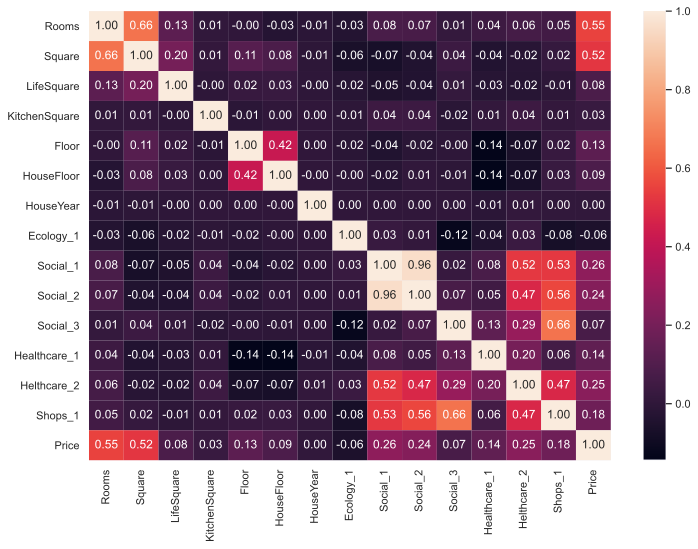

In [13]:
sns.set(rc={'figure.figsize': (11.7, 8.27)})

hm = sns.heatmap(data.corr(), annot=True, fmt='.2f')

Признаки __Social_2__ и __Social_1__ имеют очень сильную корреляцию между собой <br>
С целевой переменной __price__ имеют сильную корреляцию признаки __Rooms__ и __Square__

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax_rooms, ax_square = ax.flatten()

fig.set_size_inches(12, 6)
fig.subplots_adjust(wspace=0.3, hspace=0.3)

ax_rooms.scatter(x=data["Rooms"], y=data[target])
ax_rooms.set_title('График комнат')
ax_rooms.set_xlabel('Rooms')
ax_rooms.set_ylabel(target)

ax_square.scatter(x=data["Square"], y=data[target])
ax_square.set_title('График площади')
ax_square.set_xlabel('Square')
ax_square.set_ylabel(target)

plt.show()

Есть некоторые выбросы, но что интереснее квартиры с 0 комнат и 0 площадь имеют цену. Возможно, это такие же выбросы. Хоть кол-во комнат численный признак, он больше похож на категориальный

In [15]:
target_mean = round(data[target].mean(), 2)
target_median = data[target].median()
target_mode = data[target].mode()[0]

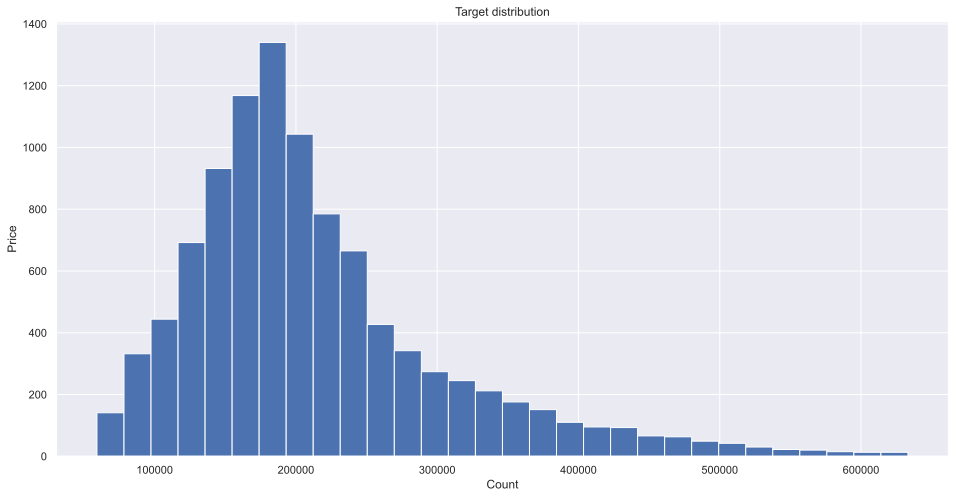

In [16]:
plt.figure(figsize=(16, 8))

data[target].hist(bins=30)
plt.xlabel("Count")
plt.ylabel("Price")
plt.title("Target distribution")
plt.show()

## 2. Обработка выбросов и пропусков

Взглянем на категориальные признаки

In [17]:
data.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [18]:
data["Id"].value_counts()

3093     1
3126     1
6503     1
7421     1
7023     1
        ..
7545     1
12908    1
2374     1
649      1
11303    1
Name: Id, Length: 10000, dtype: int64

In [19]:
data["DistrictId"].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
174      1
207      1
209      1
117      1
Name: DistrictId, Length: 205, dtype: int64

In [20]:
data["Ecology_2"].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [21]:
data["Ecology_3"].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [22]:
data["Shops_2"].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

Посмотрим на другие признаки

In [23]:
for column in data.select_dtypes(exclude='object').columns.tolist():
    print(data[column].value_counts())

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64
26.553188     1
46.363496     1
100.751999    1
70.726600     1
40.523022     1
             ..
76.481158     1
86.915187     1
82.482521     1
43.112986     1
97.664912     1
Name: Square, Length: 10000, dtype: int64
28.003539    1
19.224066    1
21.613298    1
25.688943    1
44.662105    1
            ..
37.980219    1
17.130385    1
33.273700    1
28.313300    1
28.421652    1
Name: LifeSquare, Length: 7887, dtype: int64
1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
43.0         2
112.0        2
41.0         2
32.0         2
58.0         2
25.0         2
37.0     

Обработаем эти выбросы

In [24]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        
        X.fillna(self.medians, inplace=True)
        
        return X


## 3. Feature engineering

In [25]:
class FeatureGenerator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True)
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X


## 4. Отбор признаков

In [26]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor',
                 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2',
                 'Social_3', 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier',
                     'LifeSquare_nan', 'DistrictSize', 'new_district', 'IsDistrictLarge',
                     'MedPriceByDistrict', 'MedPriceByFloorYear']

target_name = 'Price'

## 5. Разбиение на train и test

In [27]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, sep=SEPARATOR)
test_df = pd.read_csv(TEST_DATASET_PATH, sep=SEPARATOR)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [28]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [29]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

print(f"Train shape: {X_train.shape}, Valid shape: {X_valid.shape}, Test shape: {test_df.shape}")

Train shape: (6700, 22), Valid shape: (3300, 22), Test shape: (5000, 22)


In [30]:
features_gen = FeatureGenerator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

print(f"Train shape: {X_train.shape}, Valid shape: {X_valid.shape}, Test shape: {test_df.shape}")

Train shape: (6700, 29), Valid shape: (3300, 29), Test shape: (5000, 29)


In [31]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [32]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

## 6. Построение модели

In [33]:
rf_model = RandomForestRegressor(random_state=42, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

Оценка качества модели

Train R2:	0.967
Test R2:	0.671


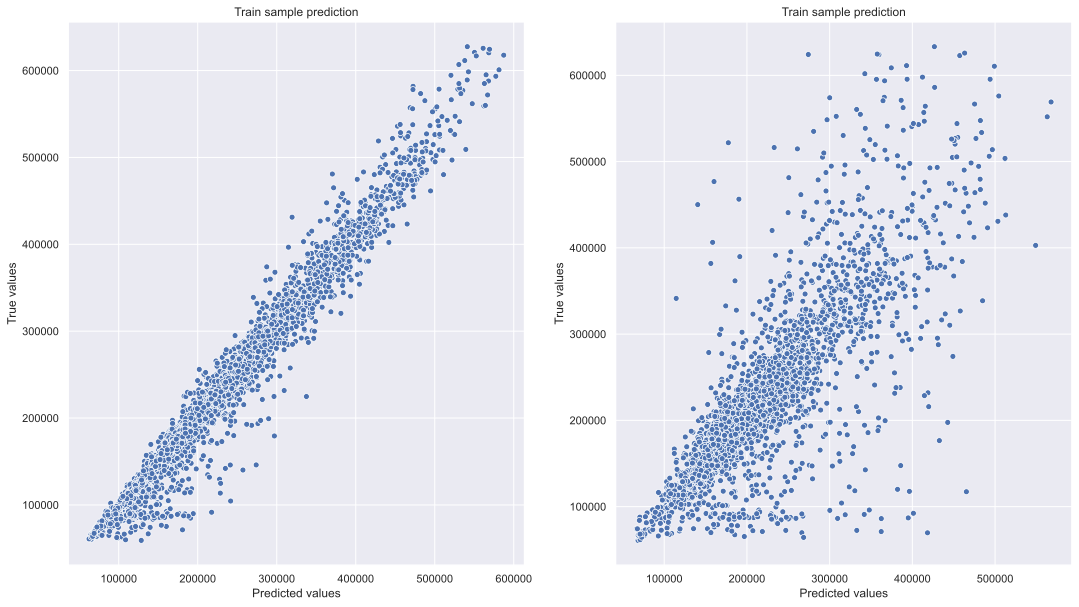

In [34]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

Попробуем другие методы

In [35]:
scaler = StandardScaler()

train_scaled_data = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
test_scaled_data = pd.DataFrame(scaler.transform(X_valid), columns=X_valid.columns)

In [36]:
tsne = TSNE(n_components=2, learning_rate=150, random_state=42)

train_tsne_df = tsne.fit_transform(train_scaled_data)

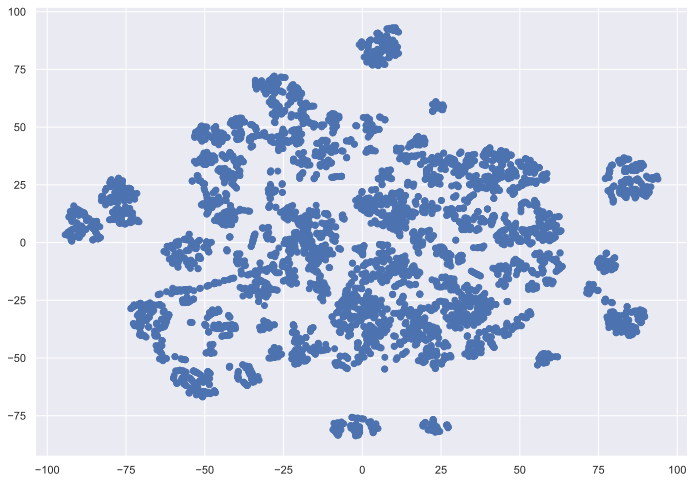

In [37]:
plt.scatter(train_tsne_df[:, 0], train_tsne_df[:, 1])
plt.show()

Выглядит странно, никаких новых данных нет

In [38]:
lr = LinearRegression()

lr.fit(train_scaled_data, y_train)

LinearRegression()

In [41]:
y_test_pred = lr.predict(test_scaled_data)

r2(y_valid, y_test_pred)

0.3533939064186029

Слабая линейная зависимость, линейная регрессия даёт плохую метрику

# Predict test data

In [49]:
submit = pd.read_csv(SAMPLE_SUBMISSION_PATH, sep=SEPARATOR)
submit.head()

Id     Price
0  4567  200000.0
1  5925  200000.0
2   960  200000.0
3  3848  200000.0
4   746  200000.0

In [50]:
predictions = rf_model.predict(test_df)
predictions

array([161064.58146941, 122536.09845482, 141987.03225329, ...,
       148430.78981551, 175934.52774818, 269943.02483075])

In [51]:
submit[target_name] = predictions
submit.head()

Id          Price
0  4567  161064.581469
1  5925  122536.098455
2   960  141987.032253
3  3848  154694.144070
4   746  172519.414398

In [52]:
submit.to_csv('rf_submit.csv', index=False)